In [16]:
import tensorflow as tf
import keras

device = "cuda" if tf.config.list_physical_devices("GPU") else "cpu"

# Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load data

In [17]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    "../../data/OpenAnimalTracks/cropped_imgs/train",
    image_size=(224, 224),
    batch_size=16,
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    "../../data/OpenAnimalTracks/cropped_imgs/test",
    image_size=(224, 224),
    batch_size=16,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    "../../data/OpenAnimalTracks/cropped_imgs/val",
    image_size=(224, 224),
    batch_size=16,
)

Found 2514 files belonging to 18 classes.


Found 719 files belonging to 18 classes.
Found 346 files belonging to 18 classes.


In [37]:
mobilenet = keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)

# Initially freeze the base model
mobilenet.trainable = False

# Data augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])

# Build the complete model
model = keras.Sequential([
    data_augmentation,
    mobilenet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(18, activation="softmax"),
])

In [38]:

model.compile(optimizer="adamax", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)])

# Save the model
model.save("mobilenet.keras")

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.1373 - loss: 10.9584 - val_accuracy: 0.3699 - val_loss: 9.0967
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2979 - loss: 8.8703 - val_accuracy: 0.3699 - val_loss: 8.0065
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3466 - loss: 7.8627 - val_accuracy: 0.3931 - val_loss: 7.2585
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4073 - loss: 7.0379 - val_accuracy: 0.4104 - val_loss: 6.6692
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4147 - loss: 6.4380 - val_accuracy: 0.4191 - val_loss: 6.1755
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4229 - loss: 5.9605 - val_accuracy: 0.4393 - val_loss: 5.7590
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4793 - loss: 5.4434 - val_accuracy: 0.4306 - val_loss: 5.4081
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4985 - loss: 5.0604 - val_accuracy: 

In [39]:
mobilnet = keras.models.load_model("mobilenet.keras")
mobilenet.trainable = True

fine_tune_at = len(mobilenet.layers) - 20

for layer in mobilenet.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [40]:
model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)])

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4119 - loss: 2.9213 - val_accuracy: 0.4306 - val_loss: 2.8900
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4416 - loss: 2.7654 - val_accuracy: 0.4306 - val_loss: 2.9450
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4766 - loss: 2.6233 - val_accuracy: 0.4335 - val_loss: 2.9369
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4886 - loss: 2.5909 - val_accuracy: 0.4393 - val_loss: 2.9169


In [41]:
real_ds = keras.preprocessing.image_dataset_from_directory(
    "../../data/dataset_no_oat_downsample",
    image_size=(224, 224),
    batch_size=32,
)

Found 1105 files belonging to 13 classes.


In [44]:

train_size = int(0.8 * len(real_ds))
val_size = len(real_ds) - train_size

real_train_ds = real_ds.take(train_size)
real_val_ds = real_ds.skip(train_size)

print(f"Dataset d'entraînement: {train_size} batches")
print(f"Dataset de validation: {val_size} batches")


Dataset d'entraînement: 28 batches
Dataset de validation: 7 batches


In [48]:

print("Début du fine-tuning...")


history = mobilnet.fit(
    real_train_ds,
    epochs=60,
    validation_data=real_val_ds,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)
    ]
)


finetuned_model.save("mobilenet_finetuned.keras")
print("Modèle fine-tuné sauvegardé sous 'mobilenet_finetuned.keras'")


Début du fine-tuning...
Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.0424 - loss: 5.5158 - val_accuracy: 0.0766 - val_loss: 4.5975 - learning_rate: 0.0010
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1133 - loss: 4.1551 - val_accuracy: 0.1866 - val_loss: 3.9182 - learning_rate: 0.0010
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2054 - loss: 3.6794 - val_accuracy: 0.2105 - val_loss: 3.5773 - learning_rate: 0.0010
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2498 - loss: 3.4530 - val_accuracy: 0.2344 - val_loss: 3.4146 - learning_rate: 0.0010
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2614 - loss: 3.3237 - val_accuracy: 0.2536 - val_loss: 3.2431 - learning_rate: 0.0010
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2827 - loss: 3.1408 - val_accuracy: 0.2823 - val_loss: 3.1511 - learning_rate: 0.0010
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3114 -

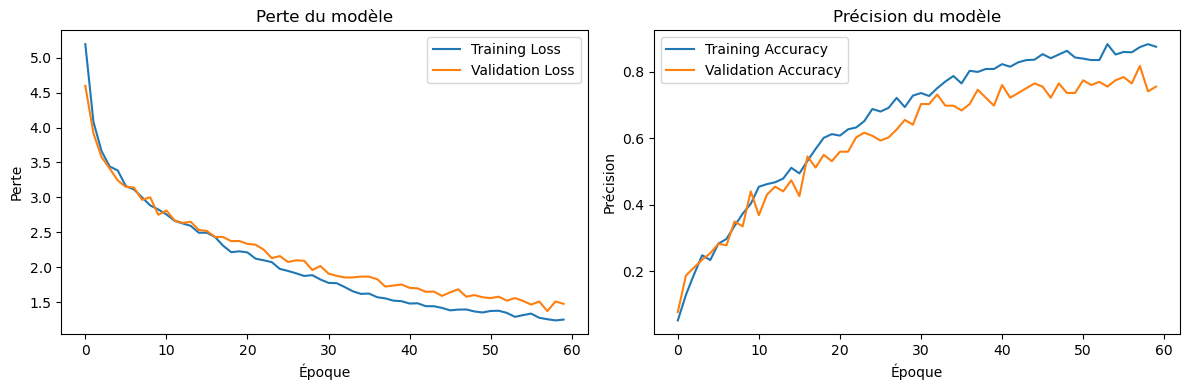

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6735 - loss: 1.9177 
Précision finale sur les données de validation: 0.6364
Perte finale sur les données de validation: 1.9867


In [50]:
# Évaluation du modèle fine-tuné
import matplotlib.pyplot as plt

# Afficher les courbes d'apprentissage
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perte du modèle')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Précision du modèle')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

# Évaluer sur l'ensemble de validation
val_loss, val_accuracy = finetuned_model.evaluate(real_val_ds)
print(f"Précision finale sur les données de validation: {val_accuracy:.4f}")
print(f"Perte finale sur les données de validation: {val_loss:.4f}")
